<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 1: Sem2 AY 23/24 - Convolutional Neural Networks (CNNs)

Module Leader: J.J. Collins

Students:  
- Pratik Verma - 23007575
- Siddharth Prince - 23052058

---
## Code checks
### Test cases
 1. Imports and setup - <span style='color: #0e0'>Passed</span>
 2. Data preprocessing and EDA - <span style='color: #0e0'>Passed</span>
 3. CNN architecture definition - <span style='color: #0e0'>Passed</span>
 4. Training - <span style='color: #0e0'>Passed</span>
 5. Metrics and evalutation - <span style='color: #0e0'>Passed</span>
 6. Finetuning model - <span style='color:orange'>waiting</span>
 7. Engineering overfitting/underfitting - <span style='color: #0e0'>Passed</span> (model is already overfitting)
---

## References
- [Sample Kaggle implementation with the Caltech-101 dataset](https://www.kaggle.com/code/ahmeddheyaa/caltech-101-image-classification/notebook)
- [Activity-6 notebook submission from semester 1 for module CE4051-Introduction to Data Engineering and Machine Learning](https://github.com/sprince0031/UL_Masters/blob/main/SEM_1/CE4051-Introduction_to_Data_Engineering_and_Machine_Learning/Week11_12/Activity6_23052058.ipynb)
- [ZFNet architecture code reference](https://github.com/vigneshthakkar/Deep-Nets/blob/master/ZFNet.py)

## 1. Imports and setup

In [21]:
import torch
from torch import nn # Importing torch's neural network (nn) class
import torch.nn.functional as F # importing this separately as 'F' to save the hasle of typing all that out. Also, it's funny.
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Caltech101
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
from torchvision import models

import matplotlib.pyplot as plt # Old faithful for plotting
import matplotlib.ticker as ticker
import numpy as np # It isn't a jupyter notebook running ML models without numpy, is it?
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import os
import time
from imutils import paths

import warnings 
warnings.filterwarnings('ignore') # To ignore the big red future warnings (we'll change our ways when things break and not premtively. 'Tis human nature.)

torch.manual_seed(69) # Setting a manual seed for consistency

In [2]:
# Pytorch version
torch.__version__

'2.2.1+cu121'

In [3]:
# Global variables
ROOT_DIR = './datasets/'
EPOCHS = 10
BATCH_SIZE = 32

### Selecting the device to use

In [4]:
# Get appropriate device for training
device = ( "cuda"     # CUDA to take advantage of Nvidia GPUs
           if torch.cuda.is_available()
           else "cpu" )   # If this fails -> CPU. Will probably use Google Colab and get a GPU.

print(f"{device} device available")

cuda device available


## 2. Data preprocessing and EDA

In [5]:
class Caltech101Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[index]
        return image, label

def load_dataset(dataset_path):
    image_paths, labels = [], []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                path = os.path.join(root, file)
                label = root.split(os.sep)[-1]
                if label != "BACKGROUND_Google":  # Exclude background images
                    image_paths.append(path)
                    labels.append(label)
    return image_paths, labels


In [6]:
# Path to your dataset
dataset_path = './datasets/caltech101/101_ObjectCategories'

# Load the dataset
image_paths, labels = load_dataset(dataset_path)

# Encode labels
lb = LabelBinarizer()
labels_binarised = lb.fit_transform(labels)
labels = np.argmax(labels_binarised, axis=1)  # Convert to indices for CrossEntropyLoss

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

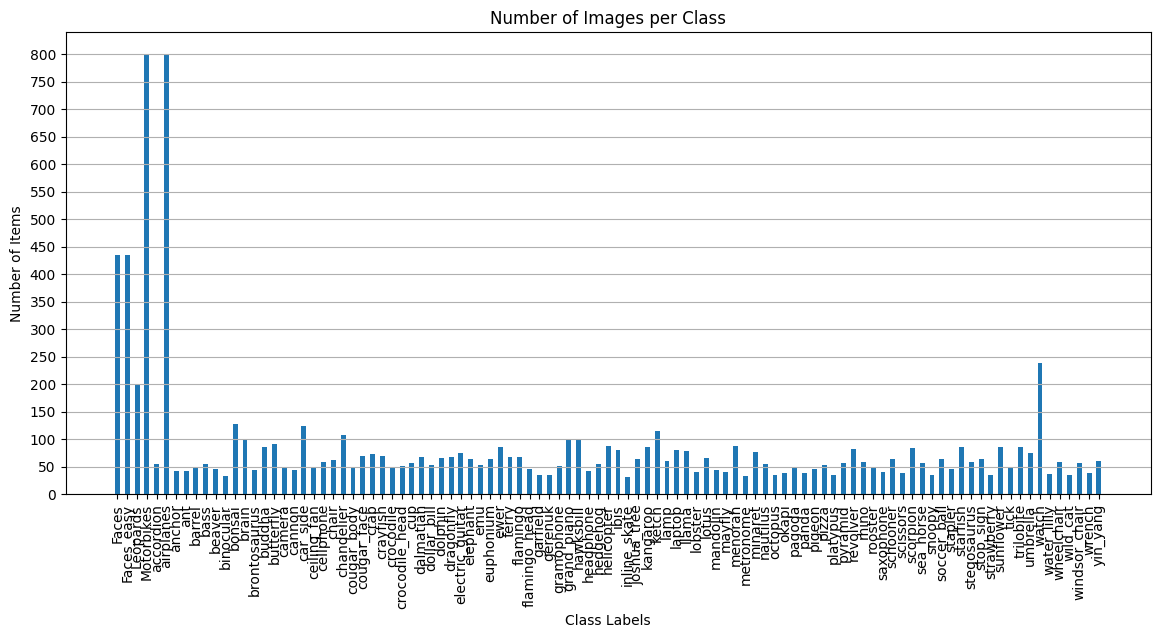

In [7]:
# Plotting a graph of the data distribution for each of the classes
labelCounts = labels_binarised.sum(axis=0)
plt.figure(figsize=(14, 6))
plt.bar(lb.classes_, labelCounts, width=0.5)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.xlabel('Class Labels')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Items')
plt.title('Number of Images per Class')
plt.grid(axis='y')
plt.show()

The data distribution in terms of the number of samples per class is very uneven as we can see from the above bar chart. Most classes have 50 or less samples which will probably affect the accuracy because of the less number of samples being trained. 

In [8]:
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# DataLoader
train_dataset = Caltech101Dataset(X_train, y_train, transform=transform)
test_dataset = Caltech101Dataset(X_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
def show_images(images, labels, classes):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()
    for img, label, ax in zip(images, labels, axs):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(classes[label])
    plt.show()

# Convert labels back to original encoding to get class names
classes = lb.classes_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

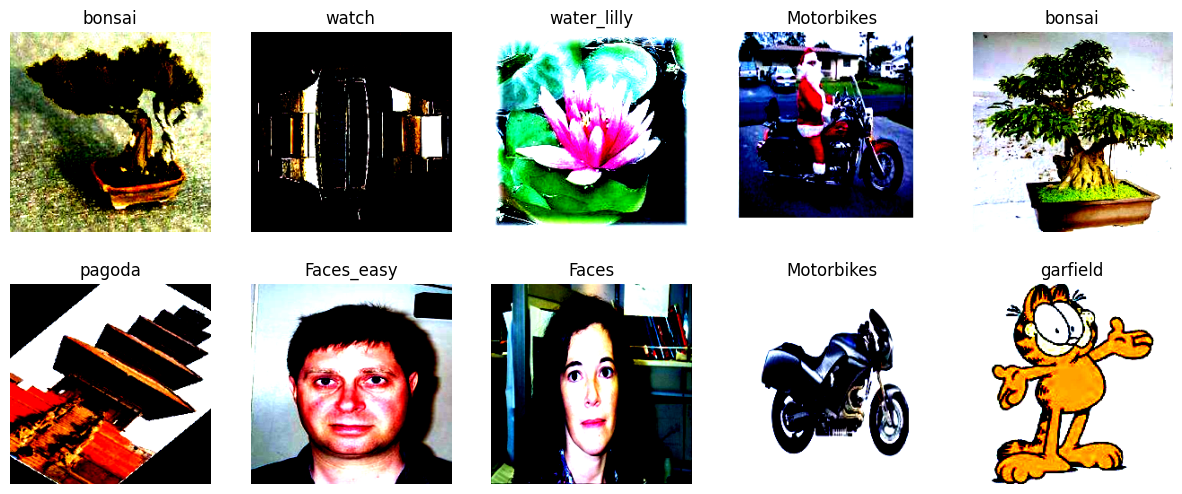

In [10]:
# Assuming 'train_dataset' is already loaded and transformed
images, labels = next(iter(train_loader))
show_images(images[:10], labels[:10], classes)

## 3. CNN Architecture Definition

### ZFNet
The ZFNet (architecture proposed by Zeiler & Fergus - [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf) ) model involves modifying the original AlexNet architecture by fine-tuning certain hyperparameters like the size of the filters and the stride and pooling sizes. ZFNet was essentially designed to understand and visualize what each layer in a ConvNet learns, but it also provided improvements over AlexNet in terms of architecture adjustments. The major change to the architecture over AlexNet is the use of 7x7 filters over 11x11 filters. The finding was that using 11x11 filters caused a loss of pixel information. Their 7x7 filter approach proved to be better at preserving more fine-grained details especially in the earlier convolutional layers.

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*tOUT7XvMctngGQwCHu_woA.png' />

*ZFNet Architecture Representation from [A Brief Overview Of ZFNet Architecture. | Medium.com](https://medium.com/@ibtedaazeem/a-brief-overview-of-zfnet-architecture-c56aa015d20f)*

In [8]:
class ZFNet(nn.Module):
    def __init__(self, num_classes=101):  # Since Caltech101 has 101 classes
        super(ZFNet, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Layer 1
            # The original ZFNet adjusted the filter size and stride in the first convolutional layer from 11x11 to 7x7.
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1), # 3 input channels (RGB), 96 filters, kernel size 7x7, stride 2, padding 1
            nn.ReLU(inplace=True), # Activation function
            nn.MaxPool2d(kernel_size=3, stride=2), # Max pooling for downsampling
            
            # Convolutional Layer 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # 96 input channels, 256 filters, kernel size 5x5, padding 2
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 3 convolutional layers with padding as shown in the architecture diagram above
            # Convolutional Layer 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 256 input channels, 384 filters, kernel size 3x3, padding 1
            nn.ReLU(inplace=True),
            # Convolutional Layer 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Convolutional Layer 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Final max pooling layer for downsampling
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Global average pooling for giving a fixed-size output
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # The following are the classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(), # Dropout for regularization to prevent overfitting
            # First fully-connected layer
            nn.Linear(256 * 6 * 6, 4096), # Input size is based on output from features and avgpool,i.e, 4096 hidden units
            nn.ReLU(inplace=True), # ReLU activation function again
            
            nn.Dropout(),
            # Second fully-connected layer
            nn.Linear(4096, 4096), # 4096 input units from previous layer, 4096 hidden units
            nn.ReLU(inplace=True),
            # Final output layer with number of units matching the number of classes (101 classes)
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        # We're now sequentially calling all the above defined layers in each forward pass.
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten for fully-connected layers
        x = self.classifier(x)
        return x

In [9]:
zfnet = ZFNet(num_classes=101).to(device)
summary(zfnet, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 112, 112]          14,208
              ReLU-2         [-1, 96, 112, 112]               0
         MaxPool2d-3           [-1, 96, 55, 55]               0
            Conv2d-4          [-1, 256, 55, 55]         614,656
              ReLU-5          [-1, 256, 55, 55]               0
         MaxPool2d-6          [-1, 256, 27, 27]               0
            Conv2d-7          [-1, 384, 27, 27]         885,120
              ReLU-8          [-1, 384, 27, 27]               0
            Conv2d-9          [-1, 384, 27, 27]       1,327,488
             ReLU-10          [-1, 384, 27, 27]               0
           Conv2d-11          [-1, 256, 27, 27]         884,992
             ReLU-12          [-1, 256, 27, 27]               0
        MaxPool2d-13          [-1, 256, 13, 13]               0
AdaptiveAvgPool2d-14            [-1, 25

## 4. Training

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # this dictates the behaviour of the class when certain functions/modules such as 'BatchNorm' are called.

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # Moves the torch tensor data to the memory of the default device selected for training.

        optimizer.zero_grad() 
        
        # Compute prediction error
        '''
        The Tensor object that holds the features on which the model is to be trained is passed to an instance of the defined model 
        class which returns the class predictions after being processed by the nn model.
        '''
        pred = model(X)

        '''
        The loss_fn (function passed as a parameter here) takes the predicted output and the actual output and returns 
        the difference according to the loss function specified. This is how we can optimise to minimise the error.
        '''
        loss = loss_fn(pred, y)

        # This is the backprop set up.
        loss.backward() #
        optimizer.step()                    #

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    now = time.time()

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    print(f'Time taken for training: {time.time() - now} seconds\n')
    return train_loss, train_accuracy, test_loss, test_accuracy

def getPreds(dataloader, model):
    model.eval()
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds += pred.argmax(1).tolist()
    return preds

In [13]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(zfnet.parameters(), lr=1e-3)

epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, zfnet, loss_fn, optimizer, epochs)

Epoch 1:

loss: 4.613897  [   32/ 6941]
loss: 3.961282  [ 3232/ 6941]
loss: 3.487323  [ 6432/ 6941]
Train Error: 
 Accuracy: 26.3%, Avg loss: 3.404923 

Test Error: 
 Accuracy: 26.3%, Avg loss: 3.395700 

Epoch 2:

loss: 3.209804  [   32/ 6941]
loss: 3.509609  [ 3232/ 6941]
loss: 3.594058  [ 6432/ 6941]
Train Error: 
 Accuracy: 35.9%, Avg loss: 2.877497 

Test Error: 
 Accuracy: 36.1%, Avg loss: 2.919647 

Epoch 3:

loss: 2.576887  [   32/ 6941]
loss: 2.750995  [ 3232/ 6941]
loss: 2.943613  [ 6432/ 6941]
Train Error: 
 Accuracy: 44.9%, Avg loss: 2.352024 

Test Error: 
 Accuracy: 44.5%, Avg loss: 2.474160 

Epoch 4:

loss: 2.493393  [   32/ 6941]
loss: 2.895628  [ 3232/ 6941]
loss: 2.318054  [ 6432/ 6941]
Train Error: 
 Accuracy: 51.4%, Avg loss: 2.000142 

Test Error: 
 Accuracy: 48.3%, Avg loss: 2.225277 

Epoch 5:

loss: 2.113620  [   32/ 6941]
loss: 1.897959  [ 3232/ 6941]
loss: 1.920785  [ 6432/ 6941]
Train Error: 
 Accuracy: 53.7%, Avg loss: 1.890086 

Test Error: 
 Accuracy: 48.

## 5. Metrics and evaluation

In [15]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot. 
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005
        
        plt.plot(X, y, label=label, marker=marker)
        
        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

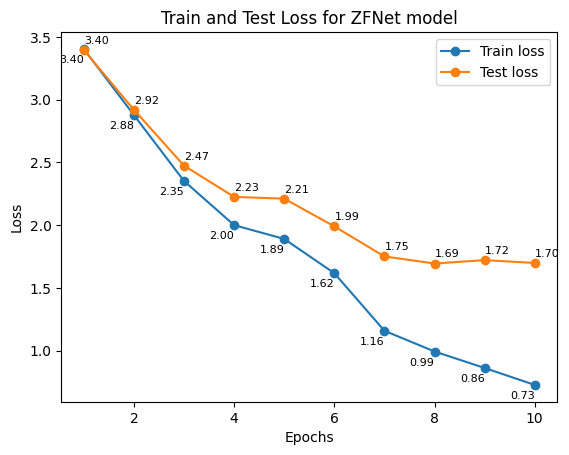

In [26]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.11, 'ha': 'right'}), 
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.05, 'ha': 'left'})]
plotTitle = 'Train and Test Loss for ZFNet model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

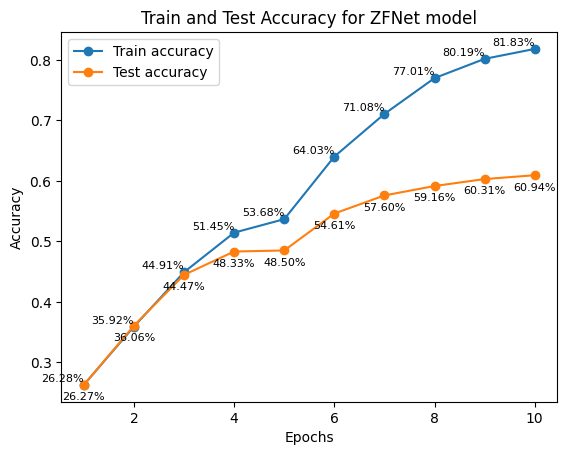

In [35]:
# Defining data and plot params
epochRange = range(1, epochs+1)
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.005,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'right'}), 
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.025,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for ZFNet model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Observations:
The model has a steady curve with both training and testing accuracies pretty much aligning until the 3rd epoch. After this, there is a small disparity between the two till epoch #5. But from here on out, it is pretty obvious that the model is overfitting to the training data as the testing accuracy is not growing nearly as much as the training accuracy.

## 6. Finetuning the model

### 6.1 Adjusting the normalisation
We noticed that some of the features in the images seem to become less pronounced due to a high contrast. The transformed image of the watch below for example is very dark and we can't see the watch face at all. This got us thinking about computing the mean and standard deviation values for normalisation from scratch for this dataset instead of using the standard ImageNet values. This makes sense because we are training a model from scratch as opposed to using a pretrained model based on ImageNet.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

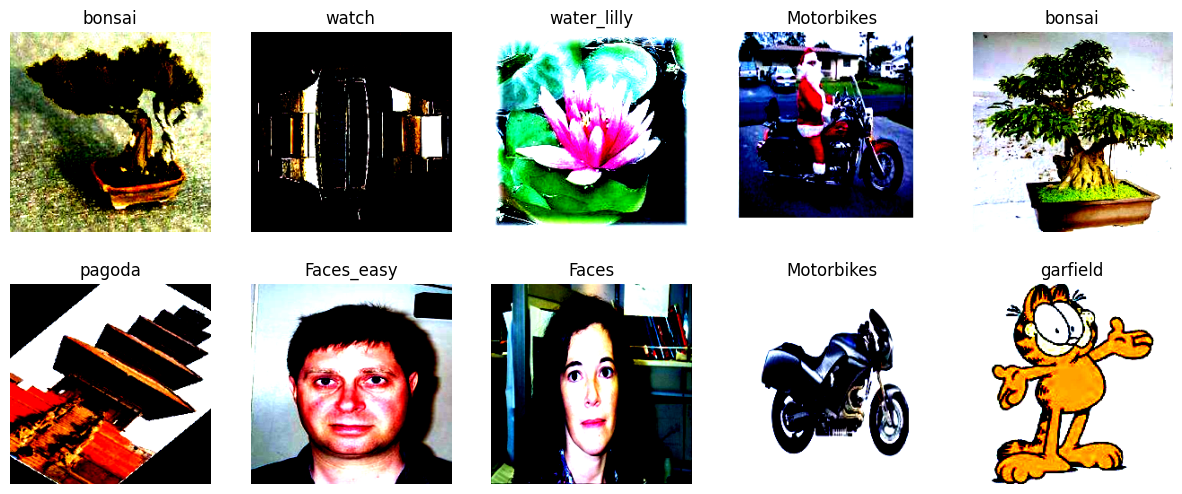

In [12]:
show_images(images[:10], labels[:10], classes)

In [25]:
transform_temp = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = Caltech101Dataset(image_paths, labels, transform_temp)

loader = DataLoader(dataset,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False,
                         drop_last=False)

mean = 0.0
for imgs, _ in loader:
    batch_samples = imgs.size(0) # gives the number of images are present in each batch
    imgs = imgs.view(batch_samples, imgs.size(1), -1) # view() reshapes the tensor. Here it is number of images, number of channels (imgs.size(1)) and the existing dimension (-1)
    mean += imgs.mean(2).sum(0) # Calculates the mean along the 2nd dimension (pixel values) and sums up all the means for all the images in the batch.
mean = mean / len(loader.dataset)

var = 0.0
pixel_count = 0
for imgs, _ in loader:
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)
    var += ((imgs - mean.unsqueeze(1))**2).sum([0,2])
    pixel_count += imgs.nelement()
std = torch.sqrt(var / pixel_count)

print(f'Mean: {mean}, std: {std}')

Mean: tensor([0.5459, 0.5288, 0.5022]), std: tensor([0.1811, 0.1777, 0.1851])


In [34]:
print(imgs.size(1))

3


In [10]:
# Transformations
transform_new = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5459, 0.5288, 0.5022], std=[0.1811, 0.1777, 0.1851]) # Using the newly computed mean and std deviation values across 3 channels
])

# DataLoader
train_dataset = Caltech101Dataset(X_train, y_train, transform=transform_new)
test_dataset = Caltech101Dataset(X_test, y_test, transform=transform_new)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

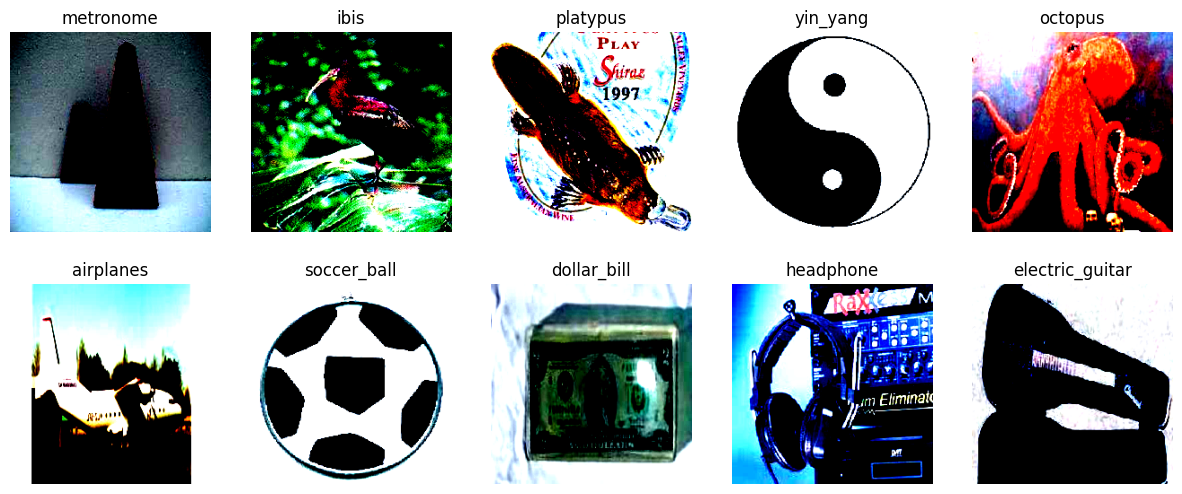

In [13]:
# Assuming 'train_dataset' is already loaded and transformed
images, labels = next(iter(train_loader))
# Convert labels back to original encoding to get class names
show_images(images[:10], labels[:10], classes)

It is hard to say from just a visual reference of a few samples (that too different ones) if the new normalisation applied does a better job of enhancing the features such as edges that better fit this dataset as opposed to the earlier values of ImageNet.

In [31]:
zfnet = ZFNet(num_classes=101).to(device)
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(zfnet.parameters(), lr=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, zfnet, loss_fn, optimizer, EPOCHS)

Epoch 1:

loss: 4.616852  [   32/ 6941]
loss: 3.501925  [ 3232/ 6941]
loss: 3.310430  [ 6432/ 6941]
Train Error: 
 Accuracy: 27.9%, Avg loss: 3.355278 

Test Error: 
 Accuracy: 27.8%, Avg loss: 3.353555 

Epoch 2:

loss: 3.338465  [   32/ 6941]
loss: 2.984560  [ 3232/ 6941]
loss: 3.991411  [ 6432/ 6941]
Train Error: 
 Accuracy: 37.2%, Avg loss: 2.783119 

Test Error: 
 Accuracy: 35.6%, Avg loss: 2.850614 

Epoch 3:

loss: 3.076688  [   32/ 6941]
loss: 2.726858  [ 3232/ 6941]
loss: 2.756002  [ 6432/ 6941]
Train Error: 
 Accuracy: 46.0%, Avg loss: 2.293580 

Test Error: 
 Accuracy: 43.7%, Avg loss: 2.471127 

Epoch 4:

loss: 3.096363  [   32/ 6941]
loss: 2.609578  [ 3232/ 6941]
loss: 2.675132  [ 6432/ 6941]
Train Error: 
 Accuracy: 53.4%, Avg loss: 1.957089 

Test Error: 
 Accuracy: 48.0%, Avg loss: 2.230197 

Epoch 5:

loss: 1.783773  [   32/ 6941]
loss: 2.133305  [ 3232/ 6941]
loss: 2.225827  [ 6432/ 6941]
Train Error: 
 Accuracy: 59.1%, Avg loss: 1.709918 

Test Error: 
 Accuracy: 51.

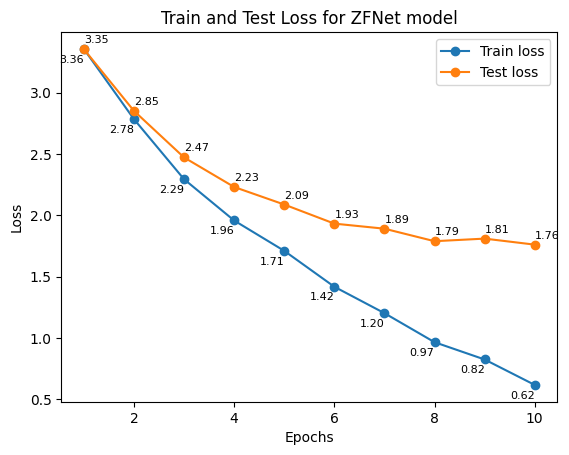

In [35]:
epochRange = range(1, EPOCHS+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.11, 'ha': 'right'}), 
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.05, 'ha': 'left'})]
plotTitle = 'Train and Test Loss for ZFNet model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

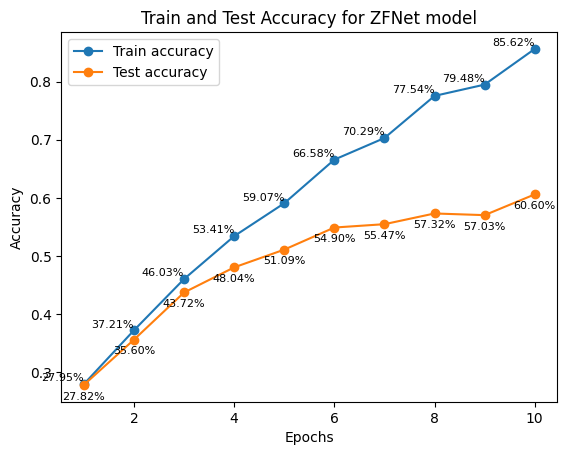

In [36]:
# Defining data and plot params
epochRange = range(1, EPOCHS+1)
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.005,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'right'}), 
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.025,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for ZFNet model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Observations:
While the training accuracy figures have increased over the same number of epochs, the testing accuracy seems to have fallen a little shy of the maximum accuracy achieved with the run using ImageNet's mean and std deviation figures for normalisation. However, the curves are smoother and seems to indicate a steady climb in its learning.

### 6.2 Tweaking hyper-parameters
The network still is overfitting to the training data. We can try to combat this by increasing the dropout rate to increase regularisation in the network during training.

In [20]:
# Defining a tweaked ZFNet architecture with changes to dropout rates.
class ZFNetNew(nn.Module):
    def __init__(self, num_classes=101):
        super(ZFNetNew, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.45), # Decreasing the dropout probablilty to 0.45 instead of default 0.5
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.55), # Increasing the dropout probablilty to 0.55 instead of default 0.5
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
zfnetNew = ZFNetNew(num_classes=101).to(device)
summary(zfnetNew, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 112, 112]          14,208
              ReLU-2         [-1, 96, 112, 112]               0
         MaxPool2d-3           [-1, 96, 55, 55]               0
            Conv2d-4          [-1, 256, 55, 55]         614,656
              ReLU-5          [-1, 256, 55, 55]               0
         MaxPool2d-6          [-1, 256, 27, 27]               0
            Conv2d-7          [-1, 384, 27, 27]         885,120
              ReLU-8          [-1, 384, 27, 27]               0
            Conv2d-9          [-1, 384, 27, 27]       1,327,488
             ReLU-10          [-1, 384, 27, 27]               0
           Conv2d-11          [-1, 256, 27, 27]         884,992
             ReLU-12          [-1, 256, 27, 27]               0
        MaxPool2d-13          [-1, 256, 13, 13]               0
AdaptiveAvgPool2d-14            [-1, 25

In [12]:
# Transformations
transform_new = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5459, 0.5288, 0.5022], std=[0.1811, 0.1777, 0.1851])
])

# DataLoader
train_dataset = Caltech101Dataset(X_train, y_train, transform=transform_new)
test_dataset = Caltech101Dataset(X_test, y_test, transform=transform_new)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

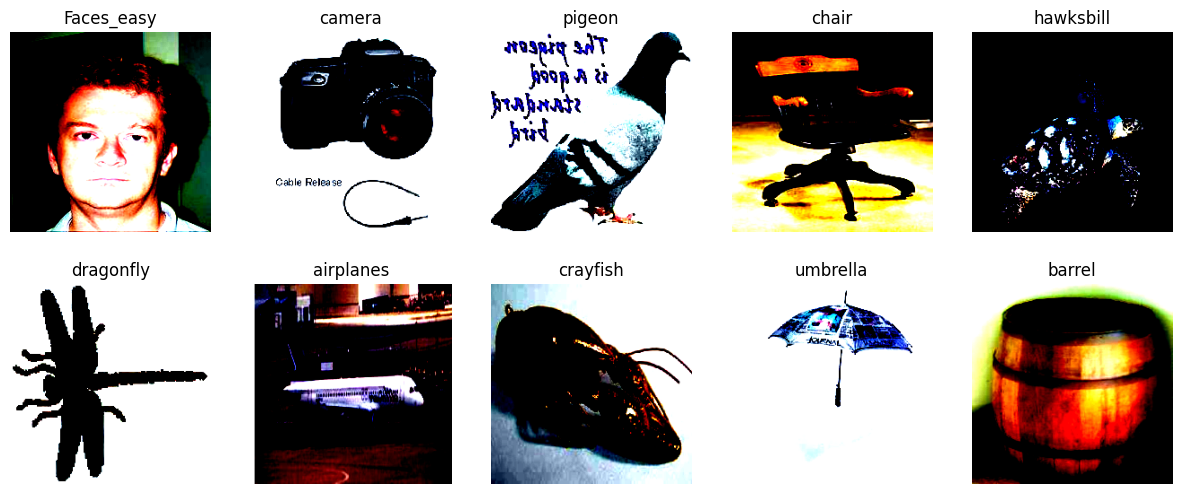

In [13]:
# Assuming 'train_dataset' is already loaded and transformed
images, labels = next(iter(train_loader))
# Convert labels back to original encoding to get class names
show_images(images[:10], labels[:10], classes)

In [17]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(zfnetNew.parameters(), lr=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, zfnetNew, loss_fn, optimizer, EPOCHS)

Epoch 1:

loss: 4.617885  [   32/ 6941]
loss: 4.001566  [ 3232/ 6941]
loss: 3.974810  [ 6432/ 6941]
Train Error: 
 Accuracy: 17.4%, Avg loss: 3.754212 

Test Error: 
 Accuracy: 17.2%, Avg loss: 3.738222 

Epoch 2:

loss: 4.228005  [   32/ 6941]
loss: 3.665565  [ 3232/ 6941]
loss: 3.779899  [ 6432/ 6941]
Train Error: 
 Accuracy: 27.4%, Avg loss: 3.364487 

Test Error: 
 Accuracy: 28.5%, Avg loss: 3.372196 

Epoch 3:

loss: 3.683521  [   32/ 6941]
loss: 3.571773  [ 3232/ 6941]
loss: 3.072074  [ 6432/ 6941]
Train Error: 
 Accuracy: 33.8%, Avg loss: 2.994090 

Test Error: 
 Accuracy: 34.2%, Avg loss: 3.005294 

Epoch 4:

loss: 3.424585  [   32/ 6941]
loss: 2.803990  [ 3232/ 6941]
loss: 3.387270  [ 6432/ 6941]
Train Error: 
 Accuracy: 39.1%, Avg loss: 2.759004 

Test Error: 
 Accuracy: 38.1%, Avg loss: 2.818462 

Epoch 5:

loss: 2.491598  [   32/ 6941]
loss: 2.678433  [ 3232/ 6941]
loss: 2.344602  [ 6432/ 6941]
Train Error: 
 Accuracy: 46.1%, Avg loss: 2.357283 

Test Error: 
 Accuracy: 43.

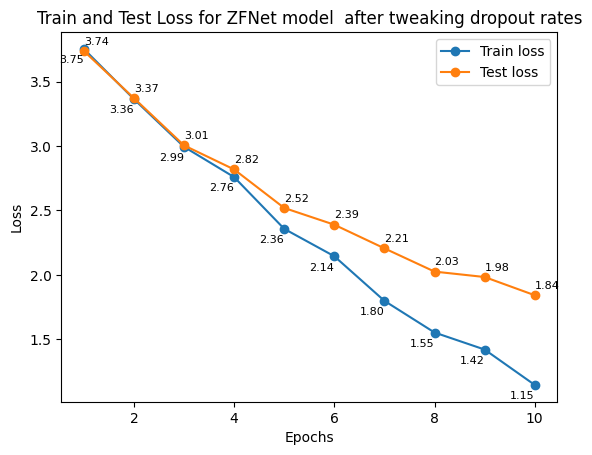

In [23]:
epochRange = range(1, EPOCHS+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.11, 'ha': 'right'}), 
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.05, 'ha': 'left'})]
plotTitle = 'Train and Test Loss for ZFNet model  after tweaking dropout rates'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

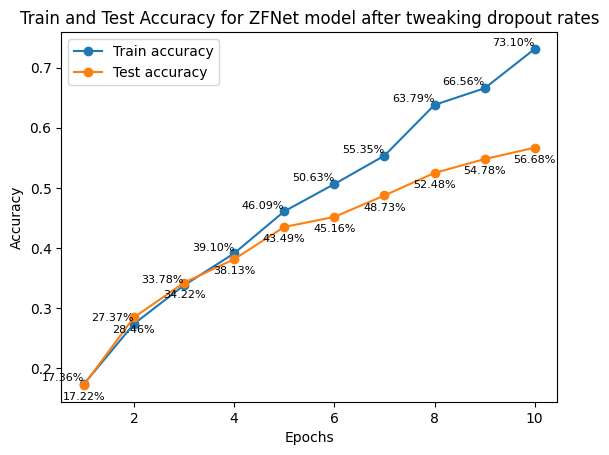

In [22]:
# Defining data and plot params
epochRange = range(1, EPOCHS+1)
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.005,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'right'}), 
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.025,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for ZFNet model after tweaking dropout rates'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

In [26]:
# Precision, Recall and F1 scores i.e, classification report
yPreds = getPreds(test_loader, zfnetNew)
yPredsWithClasses = [classes[i] for i in yPreds]
y_testWithClasses = [classes[i] for i in y_test]
print(classification_report(y_testWithClasses, yPredsWithClasses, labels=classes, zero_division=False))

                 precision    recall  f1-score   support

          Faces       0.90      0.98      0.94        87
     Faces_easy       0.98      0.98      0.98        87
       Leopards       0.67      0.93      0.78        40
     Motorbikes       0.89      0.99      0.93       160
      accordion       0.36      0.45      0.40        11
      airplanes       0.87      0.95      0.91       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.05      0.11      0.07         9
      binocular       0.44      0.57      0.50         7
         bonsai       0.33      0.23      0.27        26
          brain       0.55      0.55      0.55        20
   brontosaurus       0.20      0.11      0.14         9
         buddha       0.30      0.41      0.35        17
      butterfly       0.18    